# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score, silhouette_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans, FeatureAgglomeration
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import Normalizer
from sklearn import random_projection

In [2]:
savePath = ''

## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [4]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [5]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [6]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [7]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [8]:
lossDataBaseline, accDataBaseline, runtime = trainNN(model)

Epoch 0 - Training loss: 1.193015780252264
Testing Loss  = 0.4982403176984969
Epoch 1 - Training loss: 0.4131230804735742
Testing Loss  = 0.369062693350634
Epoch 2 - Training loss: 0.34078580967110134
Testing Loss  = 0.329886708479778
Epoch 3 - Training loss: 0.30840124597634805
Testing Loss  = 0.3016965578600859
Epoch 4 - Training loss: 0.2849058616439552
Testing Loss  = 0.27725259219385257
Epoch 5 - Training loss: 0.2638120343027365
Testing Loss  = 0.2612169731859189
Epoch 6 - Training loss: 0.24686540668958898
Testing Loss  = 0.24246155634332614
Epoch 7 - Training loss: 0.23009902923880027
Testing Loss  = 0.23241371616341505
Epoch 8 - Training loss: 0.21469221444195494
Testing Loss  = 0.22200596738298228
Epoch 9 - Training loss: 0.2009017033254742
Testing Loss  = 0.20853543053766724
Epoch 10 - Training loss: 0.18731964978834856
Testing Loss  = 0.1947351079078237
Epoch 11 - Training loss: 0.17631663440171716
Testing Loss  = 0.18774825650130866
Epoch 12 - Training loss: 0.165064024186

In [9]:
print(np.mean(runtime))
# print(runtime)

10.477271548906963


In [10]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [11]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

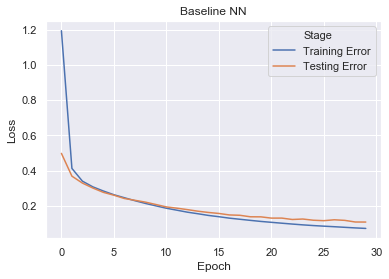

In [12]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

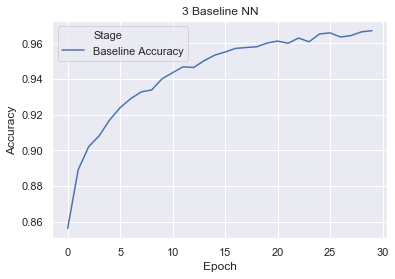

In [13]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [14]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [15]:
correctCount / allCount

0.9702

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





### Credit default dataset

In [16]:
# load dataset
creditDataDf = pd.read_excel(savePath + './data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [17]:
print(sum(creditDataDf['default payment next month']))
print(len(creditDataDf))
print(sum(creditDataDf['default payment next month'])/len(creditDataDf))


6636
30000
0.2212


In [18]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [19]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [20]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [21]:
dfColumns = creditDataDf.columns

In [22]:
# balance the dataset
ros = RandomOverSampler(random_state=37)
creditDataDf, y = ros.fit_resample(creditDataDf, y)

In [23]:
creditDataDf = pd.DataFrame(creditDataDf, columns=dfColumns)

In [24]:
print(sum(y)/len(y))

0.5


In [25]:
# standardize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

In [27]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [28]:
sum(y_train)/len(y_train)

0.5023909045310149

In [29]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))
y_val_tensor = torch.tensor(y_val.values.astype(np.int))

In [30]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [31]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

7477 9346 29905


In [32]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader2 = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [33]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [34]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [35]:
def trainTabNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # optimizer = optim.Adam(model.parameters(), lr=0.01)
    time0 = time()
    epochs = 100
    lossData = []
    accData=[]
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [36]:
lossDataBaseline, accDataBaseline, runtime = trainTabNN(modelTabBaseline)

Epoch 0 - Training loss: 0.64205660772884
Testing Loss  = 0.5992449522018433
Testing Accuracy  = 0.6811555436672462
Epoch 1 - Training loss: 0.592000718236479
Testing Loss  = 0.5801789164543152
Testing Accuracy  = 0.7048281396281931
Epoch 2 - Training loss: 0.5824898700428824
Testing Loss  = 0.5740109086036682
Testing Accuracy  = 0.7064330613882573
Epoch 3 - Training loss: 0.578427618703781
Testing Loss  = 0.5703778862953186
Testing Accuracy  = 0.706299317908252
Epoch 4 - Training loss: 0.5753527663202367
Testing Loss  = 0.567893385887146
Testing Accuracy  = 0.7081717266283268
Epoch 5 - Training loss: 0.573669637242953
Testing Loss  = 0.5655586123466492
Testing Accuracy  = 0.7085729570683429
Epoch 6 - Training loss: 0.5713806495579898
Testing Loss  = 0.5639738440513611
Testing Accuracy  = 0.7077704961883108
Epoch 7 - Training loss: 0.5698207397746224
Testing Loss  = 0.5624071359634399
Testing Accuracy  = 0.709375417948375
Epoch 8 - Training loss: 0.56871360896999
Testing Loss  = 0.5609

Testing Loss  = 0.5407588481903076
Testing Accuracy  = 0.7183362311087335
Epoch 70 - Training loss: 0.5354581398841662
Testing Loss  = 0.5406197905540466
Testing Accuracy  = 0.7210111007088404
Epoch 71 - Training loss: 0.535622421429198
Testing Loss  = 0.5421143174171448
Testing Accuracy  = 0.7180687441487228
Epoch 72 - Training loss: 0.5349869745918828
Testing Loss  = 0.5413464307785034
Testing Accuracy  = 0.7148589006285944
Epoch 73 - Training loss: 0.5352367821157488
Testing Loss  = 0.5397845506668091
Testing Accuracy  = 0.7219473050688779
Epoch 74 - Training loss: 0.5343396672580996
Testing Loss  = 0.539264440536499
Testing Accuracy  = 0.7212785876688511
Epoch 75 - Training loss: 0.5345114119924032
Testing Loss  = 0.5396451950073242
Testing Accuracy  = 0.7160625919486425
Epoch 76 - Training loss: 0.5345952368826947
Testing Loss  = 0.5396631360054016
Testing Accuracy  = 0.7194061789487762
Epoch 77 - Training loss: 0.5337052531858795
Testing Loss  = 0.5405011773109436
Testing Accurac

In [37]:
print(np.mean(runtime))
# print(runtime)

1.1298108434677123


In [38]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, testloader2, criterion)

In [39]:
correctCount/allCount

0.7233040873100792

In [40]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

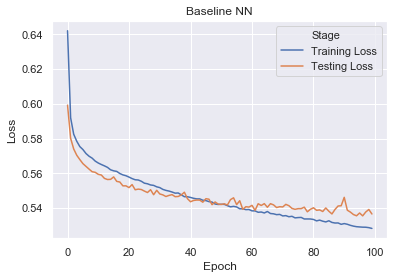

In [41]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Baseline NN')

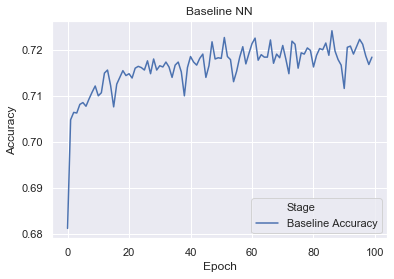

In [42]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

# Clustering algorithms

## MNIST

In [43]:
np_MNIST_trainset = np.nan_to_num(trainset.dataset.data.numpy())
np_MNIST_testset = np.nan_to_num(testset.data.numpy())

np_MNIST_trainset_y = np.nan_to_num(trainset.dataset.targets.numpy())
np_MNIST_testset_y = np.nan_to_num(testset.targets.numpy())

In [44]:
np_MNIST_trainset, np_MNIST_valset, np_MNIST_trainset_y, np_MNIST_valset_y = train_test_split(
    np_MNIST_trainset, np_MNIST_trainset_y, test_size=10000, random_state=42
    )

In [45]:
np_MNIST_trainset = np_MNIST_trainset.reshape(50000, 784)
np_MNIST_testset = np_MNIST_testset.reshape(10000, 784)
np_MNIST_valset = np_MNIST_valset.reshape(10000, 784)

### K-MEANS

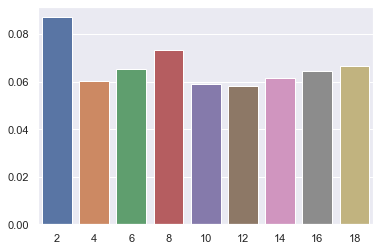

In [46]:
# calculating optimal number of clusters
silhouette_scores = []
elbow_scores = []

for i in np.arange(2, 20, 2):
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    silhouette_scores.append(silhouette_score(np_MNIST_trainset, kmeans.fit_predict(np_MNIST_trainset)))
    elbow_scores.append(kmeans.inertia_)

x = np.arange(2, 20, 2)
sns_plot = sns.barplot(x=x, y=silhouette_scores).set_title('Silhouette scores - MNIST')
sns_plot.get_figure().savefig(savePath + "kmeans-silhouette.png", dpi=100)

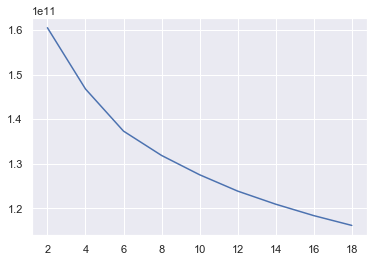

In [47]:
sns_plot = sns.lineplot(x=x, y=elbow_scores).set_title('Elbow method - MNIST')
sns_plot.get_figure().savefig(savePath + "kmeans-elbow.png", dpi=100)

In [48]:
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset)

In [49]:
# Some of the following was inspired by: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

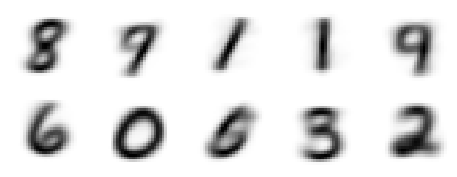

In [50]:
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [51]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

In [52]:
accuracy_score(np_MNIST_trainset_y, labels)

0.58258

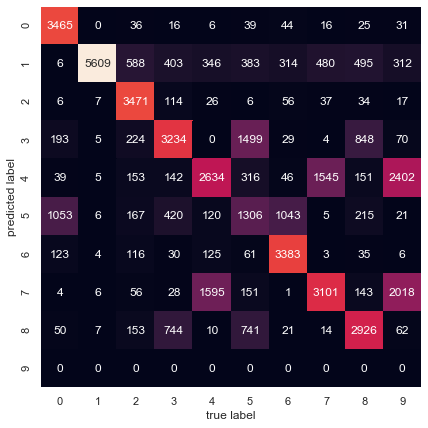

In [53]:
mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [54]:
# end of citation

## EM

In [55]:
# # We have to reduce dimensionality because of run-time
# pca = PCA(0.90, whiten=False)
# np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)
# np_MNIST_trainset_reduced.shape

(50000, 87)

2
4
6
8
10
12
14
16
18


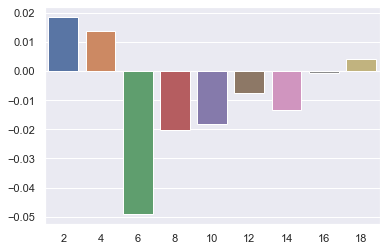

In [56]:
# calculating optimal number of clusters
silhouette_scores = []
for i in np.arange(2, 20, 2):
    print(i)
    em = GaussianMixture(n_components=i, random_state=0)
    silhouette_scores.append(silhouette_score(np_MNIST_trainset, em.fit_predict(np_MNIST_trainset)))

x = np.arange(2, 20, 2)
ax = sns.barplot(x=x, y=silhouette_scores)

In [179]:
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset)

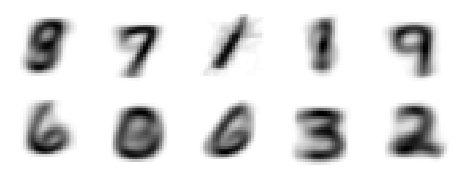

In [180]:
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = em.means_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [181]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

In [182]:
accuracy_score(np_MNIST_trainset_y, labels)

0.39474

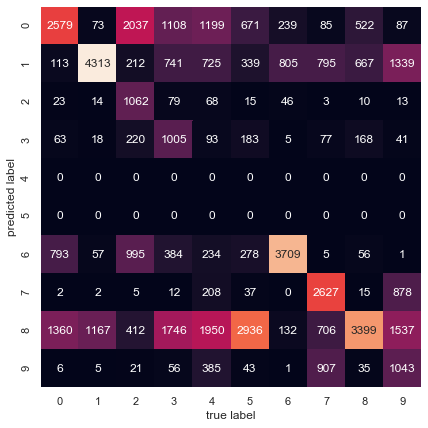

In [183]:
mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

## Credit

In [62]:
# standardize the data
x = X_train.values #returns a numpy array
normalizer = Normalizer().fit(x)
x_scaled = normalizer.transform(x)
X_train_normalized = pd.DataFrame(x_scaled, columns=X_train.columns)

## K-means

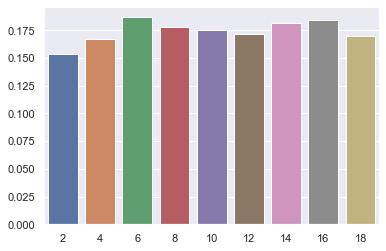

In [63]:
# calculating optimal number of clusters
silhouette_scores = []
elbow_scores = []

for i in np.arange(2, 20, 2):
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    silhouette_scores.append(silhouette_score(X_train_normalized, kmeans.fit_predict(X_train_normalized)))
    elbow_scores.append(kmeans.inertia_)

x = np.arange(2, 20, 2)
ax = sns.barplot(x=x, y=silhouette_scores)

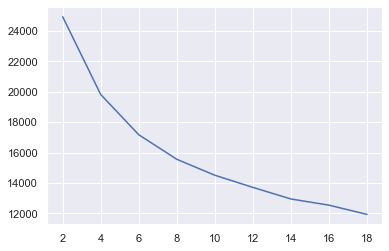

In [64]:
ax = sns.lineplot(x=x, y=elbow_scores)

In [65]:
kmeans = KMeans(n_clusters=2, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized)

In [66]:
np.unique(clusters, return_counts=True)

(array([0, 1], dtype=int32), array([12666, 17239]))

In [67]:
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

In [68]:
accuracy_score(y_train, labels)

0.5823106503929109

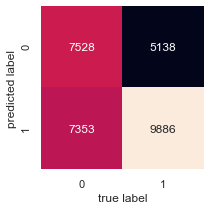

In [69]:
mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(3, 3)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

## EM

2
4
6
8
10
12
14
16
18


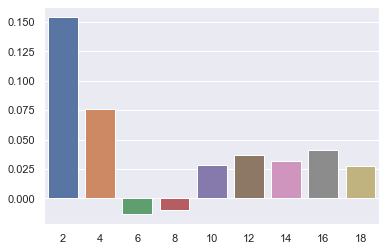

In [184]:
# calculating optimal number of clusters
silhouette_scores = []
for i in np.arange(2, 20, 2):
    print(i)
    em = GaussianMixture(n_components=i, random_state=0)
    silhouette_scores.append(silhouette_score(X_train, em.fit_predict(X_train)))

x = np.arange(2, 20, 2)
ax = sns.barplot(x=x, y=silhouette_scores)

In [185]:
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train)

In [186]:
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

In [187]:
accuracy_score(y_train, labels)

0.5701722120046815

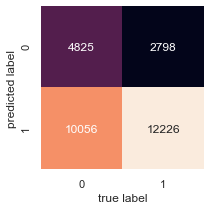

In [188]:
mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(3, 3)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

# Dimensionality reduction algorithms

## PCA

### MNIST

In [74]:
pca = PCA(2, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

Projection into 2D space

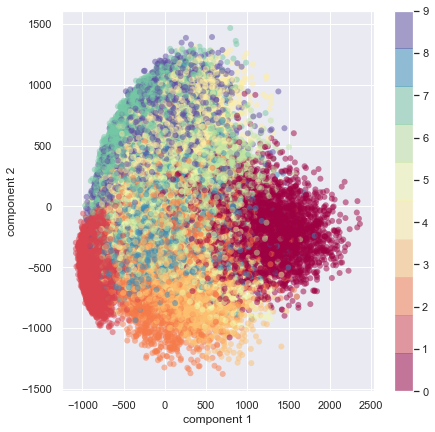

In [75]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [198]:
pca = PCA(0.9, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

In [199]:
np_MNIST_trainset_reduced.shape

(50000, 87)

In [200]:
pca.explained_variance_

array([333656.56509271, 243244.21106854, 212347.11674655, 185190.0261287 ,
       166870.84253403, 147968.46595142, 112302.835557  ,  98963.70595728,
        94633.02903894,  80882.25139024,  72538.47362887,  69067.30156627,
        58760.17622357,  58178.82928674,  54150.23252299,  50780.81745099,
        45460.54779631,  44080.03932357,  40609.13817195,  39375.9271604 ,
        36595.65913723,  34441.22403951,  32621.69093741,  31356.24121184,
        30398.16739657,  28865.01177791,  27914.27250414,  26936.35515244,
        25547.5705536 ,  23580.03372437,  22593.18148598,  22128.39744868,
        20640.75454268,  20066.48485189,  19595.82866024,  18638.77948376,
        17401.36593329,  16659.91013544,  16532.98684199,  16227.81075773,
        15642.67495026,  15233.74119214,  14423.24264156,  13725.69686768,
        13205.03785247,  12851.38030821,  12428.86424764,  12092.84942069,
        11645.21715017,  11032.32034545,  10977.67565683,  10734.83587965,
        10194.08769581,  

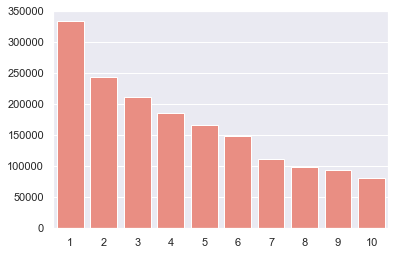

In [201]:
ax = sns.barplot(
    x=np.arange(1,11,1), 
    y=pca.explained_variance_[:10],
    color='salmon'
)

Main eigenvectors

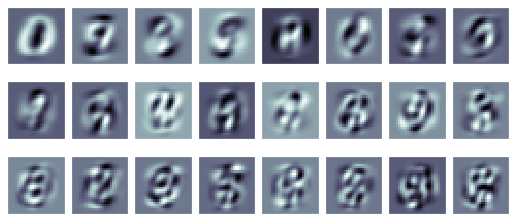

In [79]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(28, 28), cmap='bone')

Reconstruction

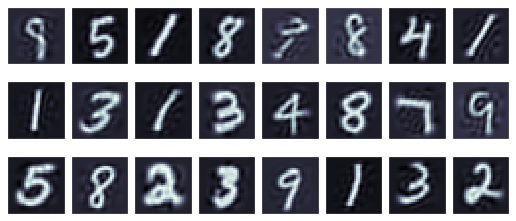

In [80]:
reconstructed = pca.inverse_transform(np_MNIST_trainset_reduced)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

### Credit

In [81]:
pca = PCA(2, whiten=False)
X_train_reduced = pca.fit_transform(X_train)

Projection into 2D space

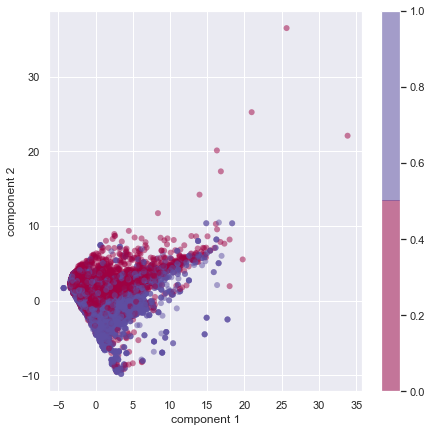

In [82]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [202]:
pca = PCA(0.9, whiten=False)
X_train_reduced = pca.fit_transform(X_train)

In [203]:
X_train_reduced.shape

(29905, 17)

In [204]:
pca.explained_variance_

array([6.59324992, 4.356024  , 2.43035181, 1.68594098, 1.59840999,
       1.22649787, 1.05713676, 1.02153315, 1.01329524, 0.95070566,
       0.93066543, 0.8797044 , 0.8451467 , 0.82334456, 0.78091728,
       0.76796348, 0.70059968])

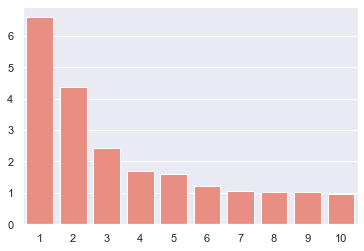

In [205]:
ax = sns.barplot(
    x=np.arange(1,11,1), 
    y=pca.explained_variance_[:10],
    color='salmon'
)

## ICA

### MNIST

In [86]:
ica = FastICA(n_components=2, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

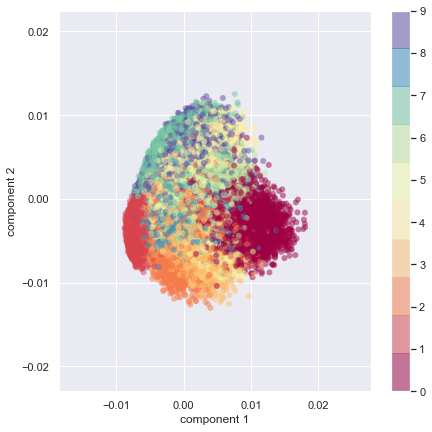

In [87]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [88]:
ica = FastICA(n_components=40, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

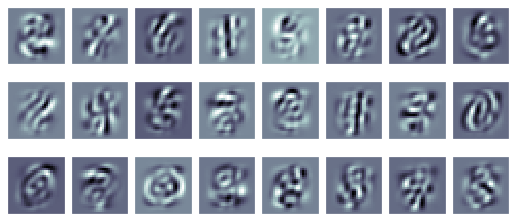

In [89]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(ica.components_[i].reshape(28, 28), cmap='bone')

Reconstruction

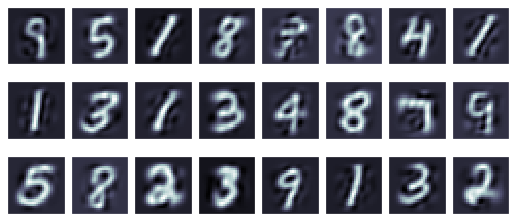

In [90]:
reconstructed = ica.inverse_transform(np_MNIST_trainset_reduced)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

### Credit

In [91]:
ica = FastICA(n_components=2, random_state=0, whiten=True)
X_train_reduced = ica.fit_transform(X_train)

Projection onto 2D space

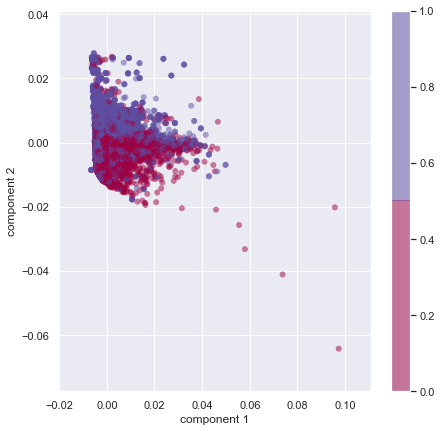

In [92]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [93]:
ica = FastICA(n_components=40, random_state=0, whiten=True)
X_train_reduced = ica.fit_transform(X_train)

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 30
  % n_components


In [94]:
X_train_reduced.shape

(29905, 30)

## Randomized projection

### MNIST

In [95]:
transformer = random_projection.GaussianRandomProjection(n_components=2)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

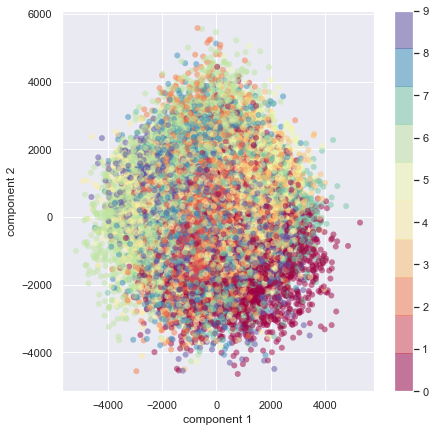

In [96]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [97]:
transformer = random_projection.GaussianRandomProjection(n_components=40)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

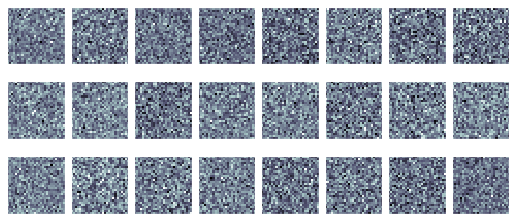

In [98]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(transformer.components_[i].reshape(28, 28), cmap='bone')

Reconstruction

In [99]:
np_MNIST_trainset_reduced.shape

(50000, 40)

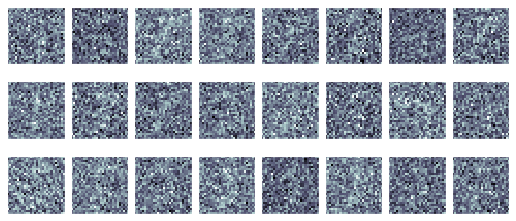

In [100]:
reconstructed = np.dot(np_MNIST_trainset_reduced, transformer.components_)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

### Credit

In [101]:
transformer = random_projection.GaussianRandomProjection(n_components=2)
X_train_reduced = transformer.fit_transform(X_train)

Projection onto 2D space

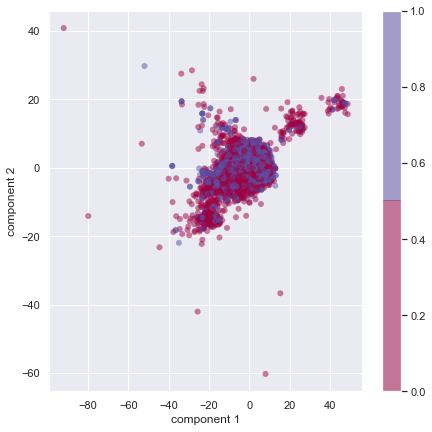

In [102]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [103]:
transformer = random_projection.GaussianRandomProjection(n_components=40)
X_train_reduced = transformer.fit_transform(X_train)

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (30 < 40).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


## My dimensionality reduction algorithm - Feature agglomeration

### MNIST

In [104]:
agglo = FeatureAgglomeration(2)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

Projection into 2D space

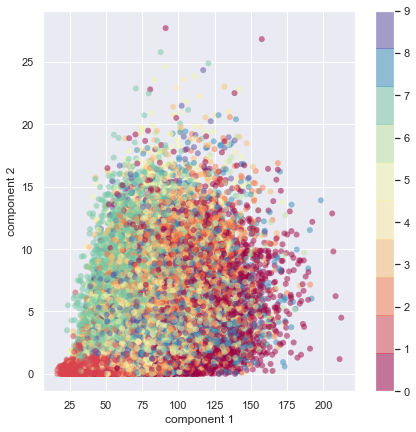

In [105]:
plt.figure(figsize=(7, 7))
plt.scatter(np_MNIST_trainset_reduced[:, 0], np_MNIST_trainset_reduced[:, 1],
            c=np_MNIST_trainset_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [106]:
agglo = FeatureAgglomeration(n_clusters=80)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

Reconstruction

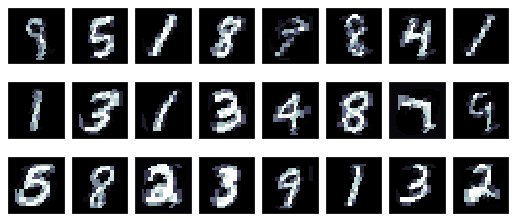

In [107]:
reconstructed = agglo.inverse_transform(np_MNIST_trainset_reduced)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed[i].reshape(28, 28), cmap='bone')

# Clustering after dimensionality reduction

## MNIST

In [108]:
# number of features to reduce to
n = 49

### PCA - KM

0.58288


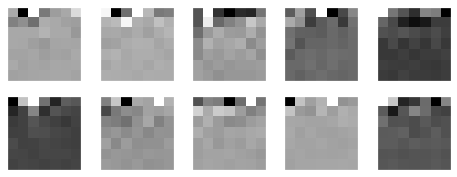

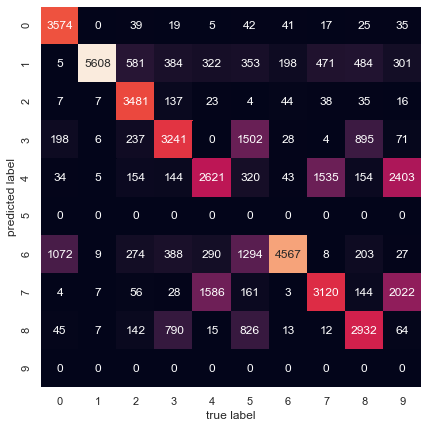

In [109]:
# dim reduction
pca = PCA(n, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

### PCA - EM

0.64132


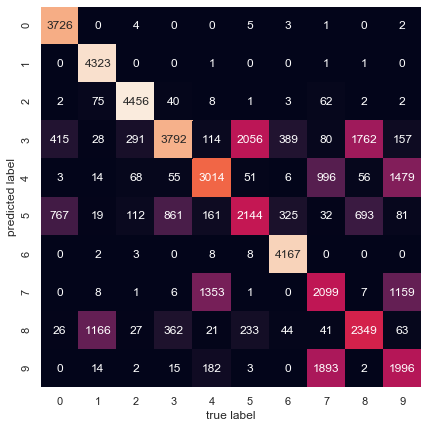

In [110]:
# dim reduction
pca = PCA(n, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - KM

0.49954


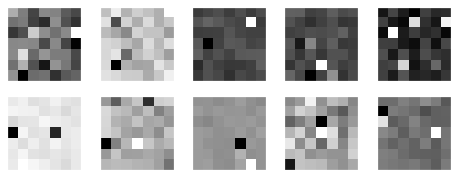

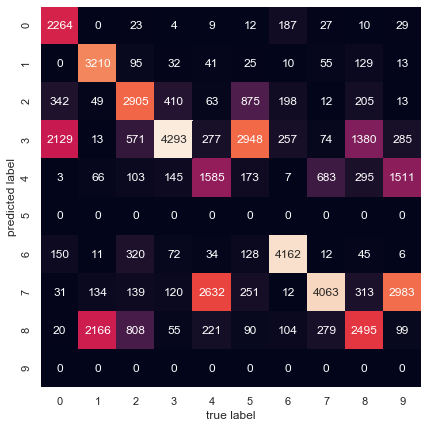

In [111]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - EM

0.69426


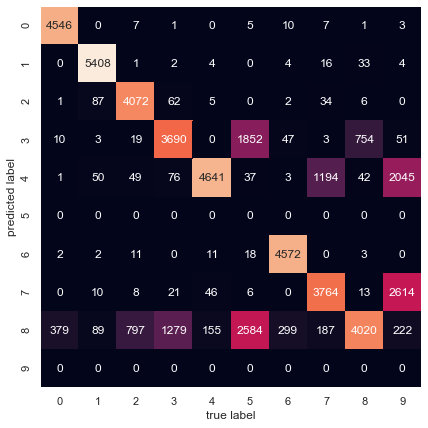

In [112]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
np_MNIST_trainset_reduced = ica.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - KM

0.46572


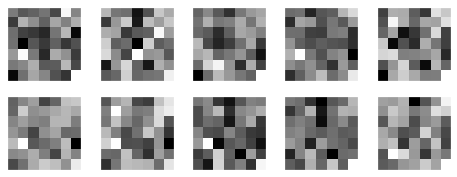

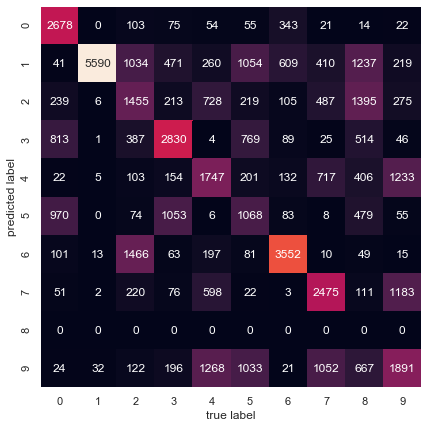

In [113]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - EM

0.6581


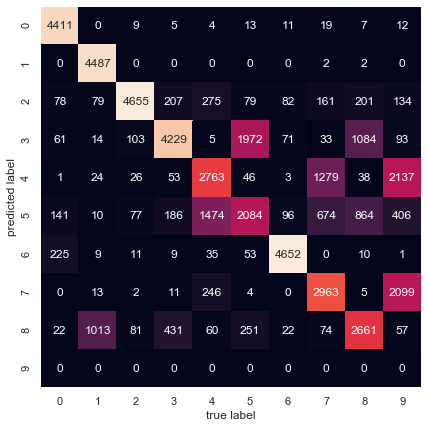

In [114]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
np_MNIST_trainset_reduced = transformer.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - KM

0.57746


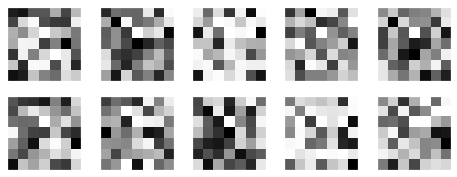

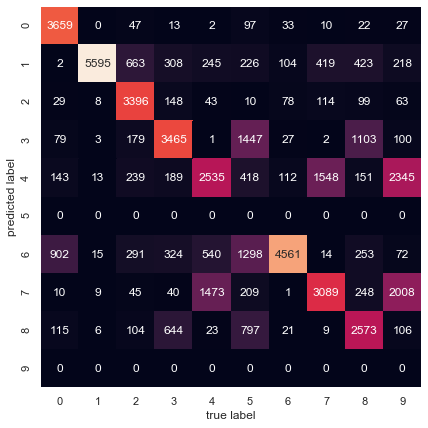

In [115]:
# dim reduction
agglo = FeatureAgglomeration(n)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

# clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(np_MNIST_trainset_reduced)

# plot
# visualize cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, int(n ** (1/2)), int(n ** (1/2)))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - EM

0.49424


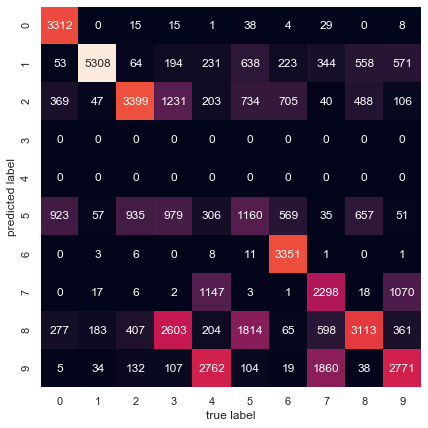

In [116]:
# dim reduction
agglo = FeatureAgglomeration(n)
np_MNIST_trainset_reduced = agglo.fit_transform(np_MNIST_trainset)

# clustering
em = GaussianMixture(n_components=10, random_state=0)
clusters = em.fit_predict(np_MNIST_trainset_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(np_MNIST_trainset_y[mask])[0]

print(accuracy_score(np_MNIST_trainset_y, labels))

mat = metrics.confusion_matrix(np_MNIST_trainset_y, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(10),
            yticklabels=np.arange(10))
plt.xlabel('true label')
plt.ylabel('predicted label');

## Credit

In [117]:
# dimensions
n = 10

### PCA - KM

0.5818759404781809


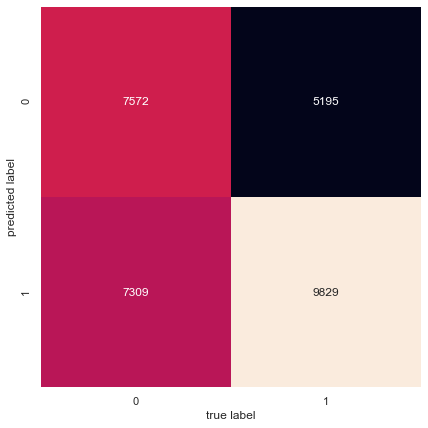

In [118]:
# dim reduction
pca = PCA(n, whiten=False)
X_train_normalized_reduced = pca.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

### PCA - EM

0.5123892325698044


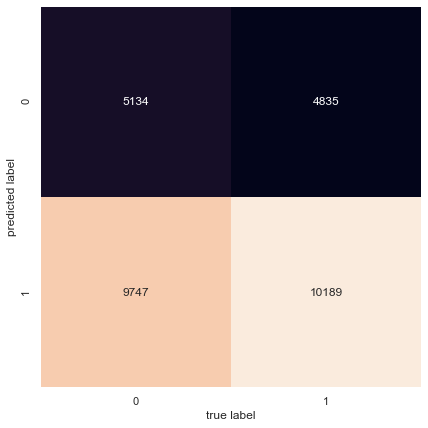

In [119]:
# dim reduction
pca = PCA(n, whiten=False)
X_train_normalized_reduced = pca.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - KM

0.5148637351613442


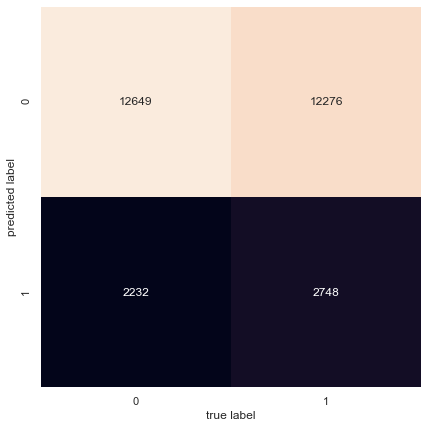

In [120]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
X_train_normalized_reduced = ica.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

### ICA - EM

0.519277712757064


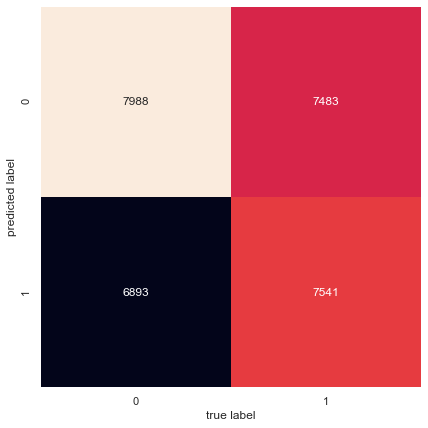

In [121]:
# dim reduction
ica = FastICA(n_components=n, random_state=0, whiten=True)
X_train_normalized_reduced = ica.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - KM

0.5723123223541214


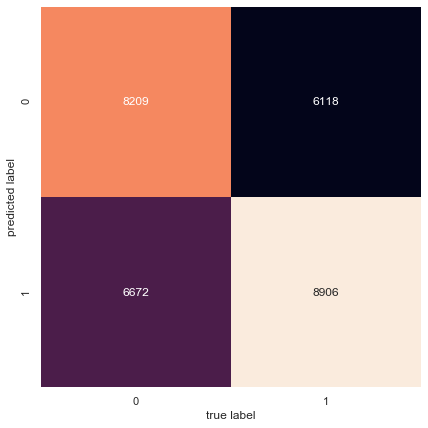

In [122]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
X_train_normalized_reduced = transformer.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

### RP - EM

0.59996656077579


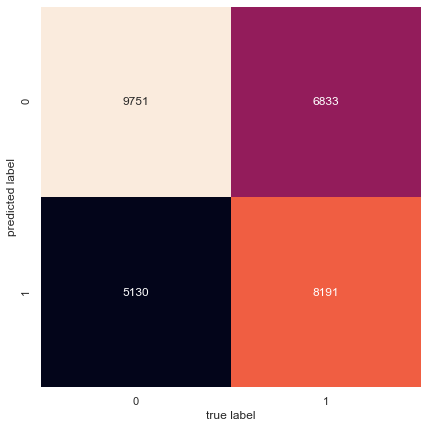

In [123]:
# dim reduction
transformer = random_projection.GaussianRandomProjection(n_components=n)
X_train_normalized_reduced = transformer.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - KM

0.5220197291422839


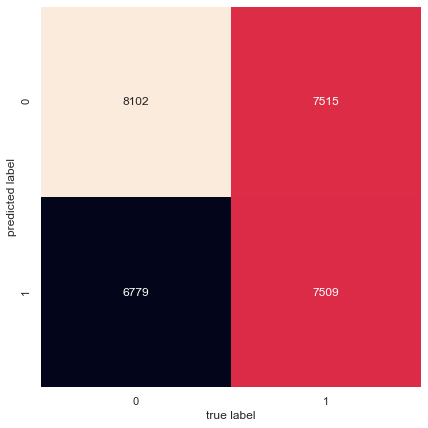

In [124]:
# dim reduction
agglo = FeatureAgglomeration(n)
X_train_normalized_reduced = agglo.fit_transform(X_train_normalized)

# clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

### MY - EM

0.5219528506938639


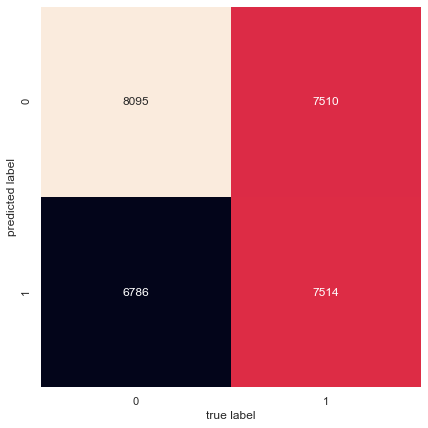

In [125]:
# dim reduction
agglo = FeatureAgglomeration(n)
X_train_normalized_reduced = agglo.fit_transform(X_train_normalized)

# clustering
em = GaussianMixture(n_components=2, random_state=0)
clusters = em.fit_predict(X_train_normalized_reduced)

# accuracy
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

print(accuracy_score(y_train, labels))

mat = metrics.confusion_matrix(y_train, labels)
plt.figure(figsize=(7, 7)) # width and height in inches
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(2),
            yticklabels=np.arange(2))
plt.xlabel('true label')
plt.ylabel('predicted label');

# Neural Network after dimensionality reduction

In [126]:
pca = PCA(128, whiten=False)
np_MNIST_trainset_reduced = pca.fit_transform(np_MNIST_trainset)

In [127]:
np_MNIST_trainset_reduced.shape

(50000, 128)

In [128]:
np_MNIST_valset_reduced = pca.transform(np_MNIST_valset)

In [129]:
np_MNIST_valset_reduced.shape

(10000, 128)

In [130]:
np_MNIST_testset_reduced = pca.transform(np_MNIST_testset)
np_MNIST_testset_reduced.shape

(10000, 128)

In [131]:
# convert data to tensors
X_train_tensor = torch.tensor(np_MNIST_trainset_reduced.astype(np.float32))
X_test_tensor = torch.tensor(np_MNIST_testset_reduced.astype(np.float32))
X_val_tensor = torch.tensor(np_MNIST_valset_reduced.astype(np.float32))

y_train_tensor = torch.tensor(np_MNIST_trainset_y.astype(np.int))
y_test_tensor = torch.tensor(np_MNIST_testset_y.astype(np.int))
y_val_tensor = torch.tensor(np_MNIST_valset_y.astype(np.int))

In [132]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [133]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

10000 10000 50000


In [134]:
trainloader = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [135]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
#         images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 128)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [136]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
#             images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [137]:
input_size = 128
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [138]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss
loss

tensor(21.6222, grad_fn=<NllLossBackward>)

In [139]:
lossDataBaseline, accDataBaseline, runtime = trainNN(model)

Epoch 0 - Training loss: 0.507439968626365
Testing Loss  = 0.22387580573558807
Epoch 1 - Training loss: 0.16745419448772755
Testing Loss  = 0.16767102479934692
Epoch 2 - Training loss: 0.1213392833396054
Testing Loss  = 0.15606652200222015
Epoch 3 - Training loss: 0.09482651393053115
Testing Loss  = 0.14300842583179474
Epoch 4 - Training loss: 0.07663108567026017
Testing Loss  = 0.1481826901435852
Epoch 5 - Training loss: 0.0658157296490509
Testing Loss  = 0.14226292073726654
Epoch 6 - Training loss: 0.054957082128988
Testing Loss  = 0.1432327777147293
Epoch 7 - Training loss: 0.042101909316343174
Testing Loss  = 0.15498654544353485
Epoch 8 - Training loss: 0.03548571656388409
Testing Loss  = 0.14240868389606476
Epoch 9 - Training loss: 0.030204942166630198
Testing Loss  = 0.15067845582962036
Epoch 10 - Training loss: 0.02721208997073097
Testing Loss  = 0.1701585352420807
Epoch 11 - Training loss: 0.023049055406793757
Testing Loss  = 0.15679050981998444
Epoch 12 - Training loss: 0.0221

In [140]:
print(np.mean(runtime))
# print(runtime)

2.0925355275472004


In [141]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [142]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

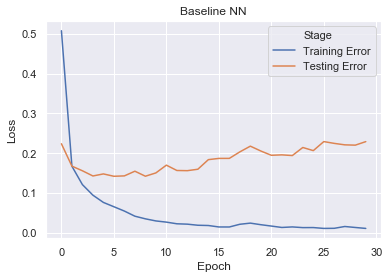

In [143]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

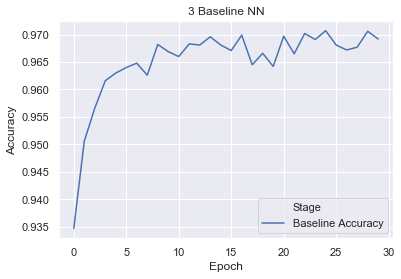

In [144]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [145]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [146]:
correctCount / allCount

0.967

# NN on clusters ater dim reductions

In [147]:
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)
np_MNIST_trainset_reduced_clustered = kmeans.fit_predict(np_MNIST_trainset_reduced)

In [148]:
np_MNIST_valset_reduced_clustered = kmeans.fit_predict(np_MNIST_valset_reduced)

In [149]:
np_MNIST_testset_reduced_clustered = kmeans.fit_predict(np_MNIST_testset_reduced)

In [150]:
# add to the full dataset
np_MNIST_trainset_reduced_clustered_appended = np.c_[np_MNIST_trainset_reduced, np_MNIST_trainset_reduced_clustered]
np_MNIST_valset_reduced_clustered_appended = np.c_[np_MNIST_valset_reduced, np_MNIST_valset_reduced_clustered]
np_MNIST_testset_reduced_clustered_appended = np.c_[np_MNIST_testset_reduced, np_MNIST_testset_reduced_clustered]

In [151]:
np_MNIST_trainset_reduced_clustered_appended.shape

(50000, 129)

In [152]:
# convert data to tensors
X_train_tensor = torch.tensor(np_MNIST_trainset_reduced_clustered_appended.astype(np.float32))
X_test_tensor = torch.tensor(np_MNIST_testset_reduced_clustered_appended.astype(np.float32))
X_val_tensor = torch.tensor(np_MNIST_valset_reduced_clustered_appended.astype(np.float32))

y_train_tensor = torch.tensor(np_MNIST_trainset_y.astype(np.int))
y_test_tensor = torch.tensor(np_MNIST_testset_y.astype(np.int))
y_val_tensor = torch.tensor(np_MNIST_valset_y.astype(np.int))

In [153]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [154]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

10000 10000 50000


In [155]:
trainloader = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [156]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
#         images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 129)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [157]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
#             images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [158]:
input_size = 129
hidden_sizes = [64, 32]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [159]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss
loss

tensor(26.5768, grad_fn=<NllLossBackward>)

In [160]:
lossDataBaseline, accDataBaseline, runtime = trainNN(model)

Epoch 0 - Training loss: 0.5736295374877313
Testing Loss  = 0.24098847806453705
Epoch 1 - Training loss: 0.20496092067169183
Testing Loss  = 0.1908576786518097
Epoch 2 - Training loss: 0.1576371354365345
Testing Loss  = 0.18635734915733337
Epoch 3 - Training loss: 0.13505662961826062
Testing Loss  = 0.17142507433891296
Epoch 4 - Training loss: 0.1150674985565693
Testing Loss  = 0.16673985123634338
Epoch 5 - Training loss: 0.1001565040963347
Testing Loss  = 0.15888719260692596
Epoch 6 - Training loss: 0.09110719482194099
Testing Loss  = 0.15121155977249146
Epoch 7 - Training loss: 0.08428014896478375
Testing Loss  = 0.16227982938289642
Epoch 8 - Training loss: 0.07484511515680019
Testing Loss  = 0.16113658249378204
Epoch 9 - Training loss: 0.06983780541830599
Testing Loss  = 0.1413237452507019
Epoch 10 - Training loss: 0.06551704136550526
Testing Loss  = 0.14028200507164001
Epoch 11 - Training loss: 0.06148400648993969
Testing Loss  = 0.15586289763450623
Epoch 12 - Training loss: 0.0569

In [161]:
print(np.mean(runtime))
# print(runtime)

1.979235021273295


In [162]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [163]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

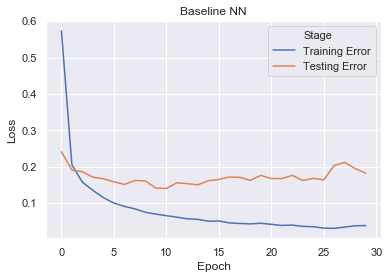

In [164]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

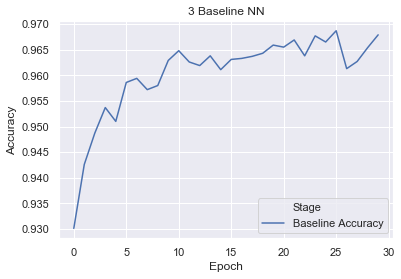

In [165]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [166]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [167]:
correctCount / allCount

0.9671

# END